In [1]:
%config InlineBackend.rc = {"figure.dpi": 72, 'figure.figsize': (6.0, 4.0)}
%matplotlib inline

import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

abtem.config.set({"local_diagnostics.progress_bar": True});

(tutorial:visualizations)=
# Visualizations

Visualizing the results is an integral part of understanding the output of a scattering simulation. The *ab*TEM visualization module wraps the `matplotlib` library to help produce typical visualizations needed when simulating transmission electron microscopy. In this tutorial, we cover how to customize the standard *ab*TEM outputs to obtain publication-ready visualizations. We note that not every customization is possible within our framework; it may sometimes be more practical to create your own visualization from scratch.

```{seealso}
This tutorial only covers static visualizations. The *ab*TEM visualization module also features [animated](examples:animations) and [interactive](examples:interactions) visualizations, see the respective examples for more information.
```

## Customizing an image ensemble

The *ab*TEM visualization module is based on the concept of ensembles of similar measurements. Given an object with one or more ensemble axes, *ab*TEM can create an "exploded" plot when you set `explode=True`. The exploded plot is a 1D or 2D grid of images or line plots, where each subplot represents a member of the ensemble.

As an example, we create HRTEM images for silicon $\{100\}$ with a single ensemble dimension representing different values of defocus.

In [2]:
atoms_cell = ase.build.bulk("Si", cubic=True)

atoms = atoms_cell * (1, 1, 100)

potential = abtem.Potential(atoms, sampling=0.05)

wave = abtem.PlaneWave(energy=100e3)

defocus = np.linspace(-80, 80, 5)

measurements = (
    wave.multislice(potential)
    .apply_ctf(defocus=defocus, Cs=10e6, semiangle_cutoff=20, focal_spread=30)
    .intensity()
    .tile((3, 3))
    .compute()
    .poisson_noise(dose_per_area=2e3, seed=100)
)

[########################################] | 100% Completed | 6.41 ss


We create a visualization using the `.show` method and set `explode=True` to create a grid plot. We set `common_color_scale=True` to show all the images on a single color scale; if this is set to `False` each image is scaled independently. We further set `cbar=True` to included a colorbar and `cmap="gray"` to show the images using a grayscale colormap (see the `matplotlib` [documentation](https://matplotlib.org/stable/gallery/color/colormap_reference.html) for a full list).

Note how each subplot is automatically labeled based on the defocus ensemble axis.

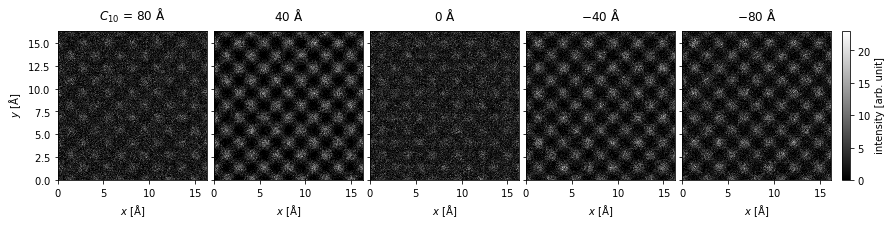

In [3]:
visualization = measurements.show(
    explode=True,
    common_color_scale=True,
    figsize=(14, 5),
    cbar=True,
    cmap="gray",
)

The `.show` method produces a `MeasurementVisualization` object, which wraps a `matplotlib` figure. Its specific subtype will depend on the type of measurement used to create the visualization – in this case, we obtain a `MeasurementVisualization2D` object.

In [4]:
object.__repr__(visualization.fig)

'<matplotlib.figure.Figure object at 0x7f9e774ef910>'

The plots are laid out using the `AxesGrid` class.

In [5]:
visualization.axes

We can convert the `AxesGrid` to a `numpy` array of `matplotlib` `Axes` as below. The `numpy` array is always 2D, hence in this case it is a `(3,1)` array, where the first dimension indexes columns.

In [6]:
np.array(visualization.axes)

array([[<Axes:xlabel='$x$ [$\\mathrm{\\AA}$]', ylabel='$y$ [$\\mathrm{\\AA}$]'>],
       [<Axes:xlabel='$x$ [$\\mathrm{\\AA}$]'>],
       [<Axes:xlabel='$x$ [$\\mathrm{\\AA}$]'>],
       [<Axes:xlabel='$x$ [$\\mathrm{\\AA}$]'>],
       [<Axes:xlabel='$x$ [$\\mathrm{\\AA}$]'>]], dtype=object)

Each `Axes` can be adjusted using the methods from `matplotlib`, but the *ab*TEM `MeasurementVisualization` implements some methods to assist in converting the standard figure to something more apporpriate for a publication.

We can adjust the vertical and horisontal spacing betwen images using the `.set_axes_padding` method; in our case we only need to adjust the horizontal spacing. The width of the colorbar can be adjusted using the `.set_cbar_size` method, and finally we can adjust the left and right padding of the colorbar using the `.set_cbar_padding` method.

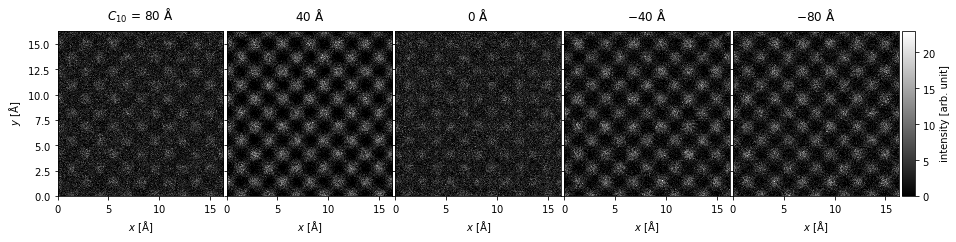

In [7]:
visualization.set_axes_padding((0.05, 0.0))
visualization.set_cbar_size(0.075)
visualization.set_cbar_padding((0.05, 0.0))

visualization.fig

We can change the units of the titles using the `.set_column_titles` method, the units of the $x$ and $y$-axis can also be changed by using the `set_x_units` or `set_y_units` methods.

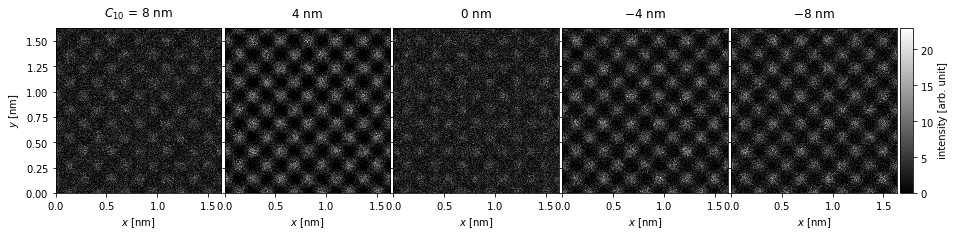

In [8]:
visualization.set_column_titles(units="nm")
visualization.set_xunits("nm")
visualization.set_yunits("nm")

visualization.fig

We can also simply remove the titles by setting them to an empty string.

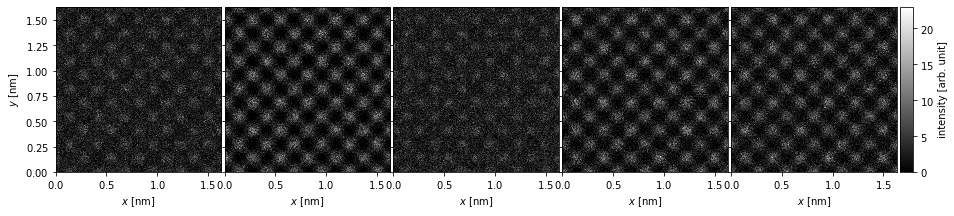

In [9]:
visualization.set_column_titles(titles="")

visualization.fig

The axes ticks and labels can be removed using the `axis_off` method, and we can add a scalebar (based on the `matplotlib` object `AnchoredSizeBar`) to preserve a description of the scale.

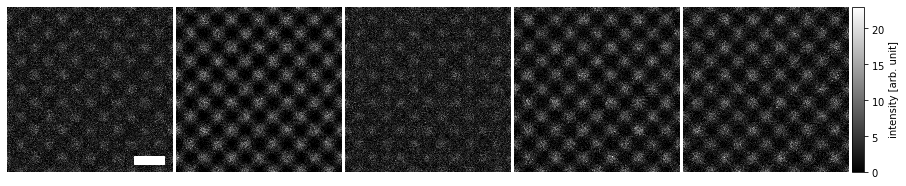

In [10]:
visualization.axis_off(spines=False)
visualization.set_scalebars(size=3, color="w")

visualization.fig

The scalebars placement within each panel can be controlled via the `loc` keyword (see `matplotlib` [documentation](https://matplotlib.org/stable/api/_as_gen/mpl_toolkits.axes_grid1.anchored_artists.AnchoredSizeBar.html)), and within the ensamble with the `panel_loc` keyword (with 'all' showing the scale bar in each plot).

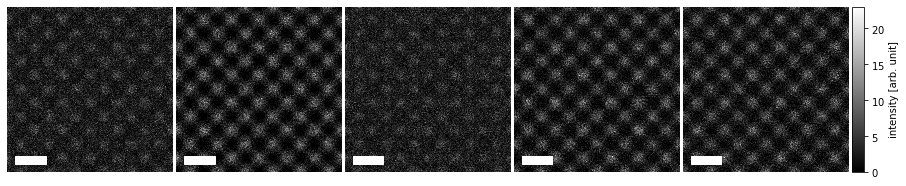

In [11]:
visualization.axis_off(spines=False)
visualization.set_scalebars(size=3, color="w", loc="lower left", panel_loc="all")

visualization.fig

Finally, we can label each image using the same metadata used for the standard titles to add annotations.

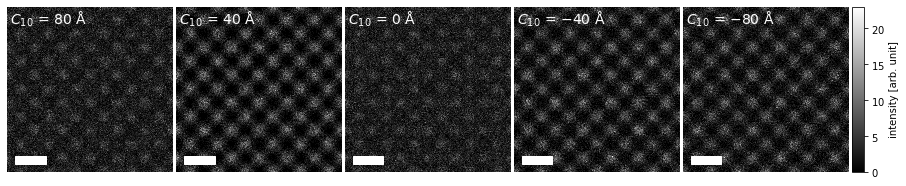

In [12]:
visualization.set_panel_labels(
    labels="metadata", frameon=False, prop={"fontsize": 14, "color": "w"}
)

visualization.fig

## 2D ensemble of images

In the next example, we demonstrate a 2D grid of graphene images for different values of defocus and spherical aberrations.

In [13]:
defocus = np.linspace(-50, 50, 7)
Cs = np.linspace(0, 400000, 5)
focal_spread = 30

atoms = ase.build.graphene(vacuum=2)

exit_wave = abtem.PlaneWave(energy=80e3, sampling=0.05).multislice(atoms)

images = (
    exit_wave.apply_ctf(defocus=defocus, Cs=Cs, focal_spread=focal_spread)
    .intensity()
    .poisson_noise(5e5)
    .compute()
)

[########################################] | 100% Completed | 517.82 ms


We create a 2D grid of images on the same color scale by setting `explode=True` and `common_color_scale=True`. Note the automatic labeling of the rows and columns.

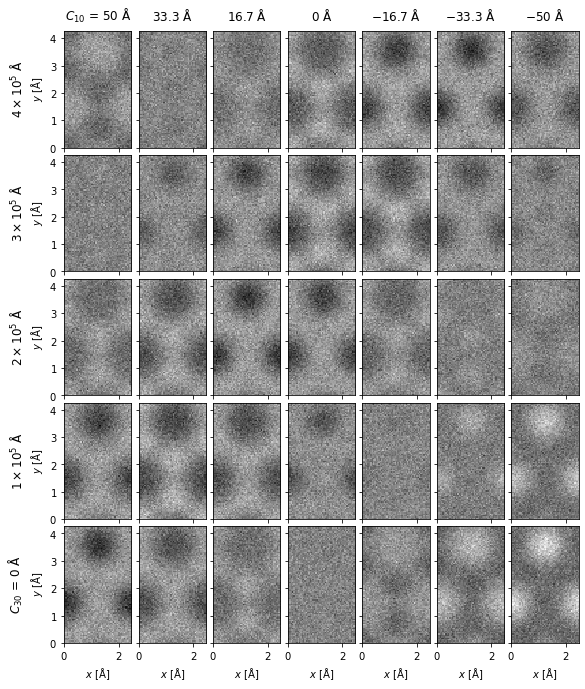

In [14]:
visualization = images.show(
    explode=True, figsize=(10, 10), common_color_scale=True, cmap="gray"
)

We can remove the spacing between the images using the `set_axes_padding` method. The axes desciptions can be removed using the `axis_off` method, and we can instead add a scalebar using the `set_scalebar` method.

In [15]:
visualization.set_axes_padding([0.0, 0.0])
visualization.axis_off(spines=False)

visualization.set_scalebars(size=1, color="w")

We can further change the units displayed in the titles using the `set_row_titles` and `set_column_titles` methods.

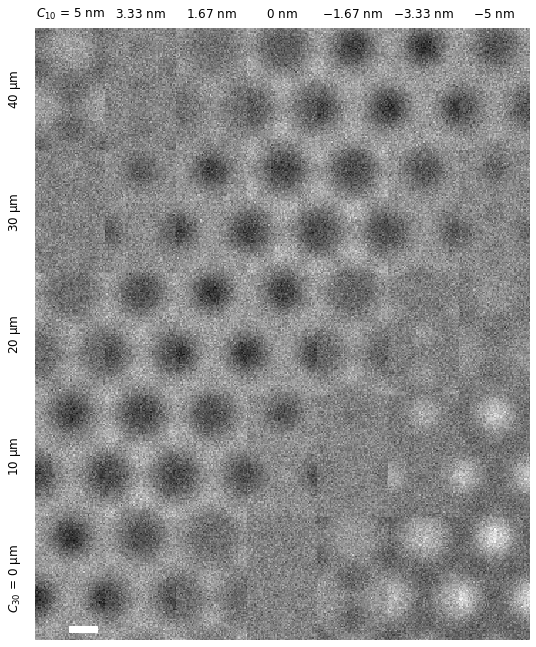

In [16]:
visualization.set_row_titles(units="um")
visualization.set_column_titles(units="nm")

visualization.fig

## Diffraction spots

The diffraction intensities calculated using a multislice simulation are concentrated in single pixels, which does not naturally make for nice visualizations. Using the indexing algorithm, we can get the positions and intensities of the diffraction spots, which can be more helpfully visualized as disks. In the example below, we create a typical textbook image of electron diffraction patterns for SiO<sub>2</sub> zeolite, where each diffraction spot is a white disk on a black background.

In [17]:
atoms_cell = ase.io.read("data/SiO2_zeolite.cif")

atoms = atoms_cell * (1, 1, 10)

potential = abtem.Potential(atoms, sampling=0.05)

wave = abtem.PlaneWave(energy=200e3)

wave.grid.match(potential)

measurements = wave.multislice(potential).compute()

spots = measurements.diffraction_patterns().index_diffraction_spots(
    cell=atoms_cell.cell, threshold=1e-4
)

[########################################] | 100% Completed | 3.52 ss


We create the visualization cropping the maximum scattering angle to $10 \ \mathrm{mrad}$, blocking the direct beam, and setting the colormap to solid white.

In [18]:
visualization = (
    spots.crop(10)
    .block_direct()
    .show(
        figsize=(8, 8),
        scale=0.1,
        cmap="w",
        display=False,
    )
)

We can access our `matplotlib` `Axes` and apply the method for setting the background color as below.

In [19]:
visualization.axes[0, 0].set_facecolor("k")

To avoid too much visual clutter, we can set a threshold for which diffraction spots are labelled with their Miller indices to an intensity of $0.0003$ (the full intensity including the direct beam should sum to $1.0$).

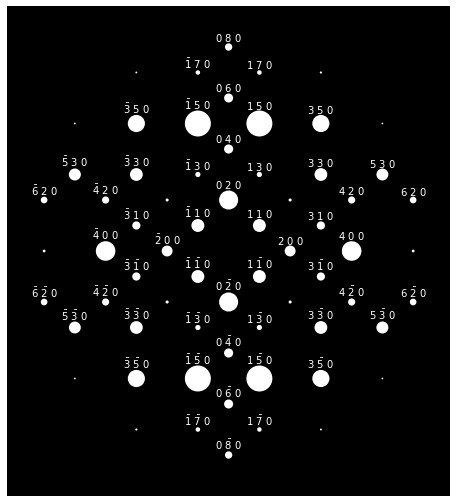

In [20]:
visualization.axis_off(spines=False)

visualization.set_miller_index_annotations(0.0003, size=10, color="w")

visualization.fig

## Domain coloring

For complex entities, phase and amplitude can be displayed simultaneously using a technique called [domain coloring](https://en.wikipedia.org/wiki/Domain_coloring).

In [21]:
probe = abtem.Probe(
    semiangle_cutoff=30,
    defocus=60,
    astigmatism=np.linspace(0, 70, 3),
    astigmatism_angle=np.pi / 4,
    gpts=256,
    extent=10,
    energy=200e3,
)
probes = probe.build().complex_images().compute()

[########################################] | 100% Completed | 310.94 ms


By default, we map the phase to colors using the ["HSLuv"](https://www.hsluv.org/) color mapping; however, the more saturated ["hsv"/"hsl"](https://en.wikipedia.org/wiki/HSL_and_HSV) mapping is also available by setting `cmap=hsv`.

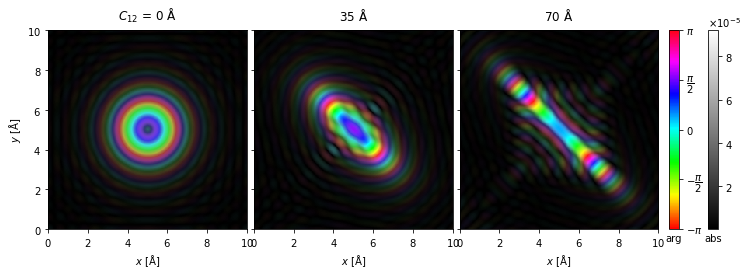

In [22]:
visualization = probes.show(
    explode=True, figsize=(12, 6), cbar=True, common_color_scale=True, cmap="hsv"
)